In [138]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [139]:
from matplotlib.font_manager import FontProperties

# Specify your font
regular = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Regular.ttf")  # Update the path to where the font is installed on your system
light = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Light.ttf")  # Update the path to where the font is installed on your system
bold = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Bold.ttf")  # Update the path to where the font is installed on your system


In [140]:
def scrape_matches(url, years, league):
    all_matches = []
    import time
    for year in years:
        data = requests.get(url)
        soup = BeautifulSoup(data.text)
        standings_table = soup.select('table.stats_table')[0]

        links = [l.get("href") for l in standings_table.find_all('a')]
        links = [l for l in links if '/squads/' in l]
        team_urls = [f"https://fbref.com{l}" for l in links]
        
        previous_season = soup.select("a.prev")[0].get("href")
        url = f"https://fbref.com{previous_season}"
        
        for team_url in team_urls:
            team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
            data = requests.get(team_url)
            matches = pd.read_html(data.text, match="Scores & Fixtures")[0]      
            team_data = matches[matches["Comp"] == league]
            team_data["Season"] = year
            team_data["Team"] = team_name
            all_matches.append(team_data)
            time.sleep(7)
    df = pd.concat(all_matches)
    df.columns = [c.lower() for c in df.columns]
    return df

In [141]:
league = 'Championship'
champ_url = "https://fbref.com/en/comps/10/Championship-Stats"
prem_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
years = list(range(2023, 2021, -1))
champ_matches = scrape_matches(champ_url, years, "Championship")
#prem_matches = scrape_matches(prem_url, years, "Premier League")

C:\Users\dmsta\AppData\Local\Temp\ipykernel_2324\3769460726.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_data["Season"] = year
C:\Users\dmsta\AppData\Local\Temp\ipykernel_2324\3769460726.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_data["Team"] = team_name
C:\Users\dmsta\AppData\Local\Temp\ipykernel_2324\3769460726.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [142]:
df = champ_matches

In [143]:
df.sort_values(["team","date"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [144]:
df['xgd'] = df['xg'] - df['xga']

In [145]:
df['xgd ma'] = df.groupby('team')['xgd'].transform(lambda x: x.rolling(12).mean())
df['xgd ma'] = df['xgd ma'].round(2)

In [146]:
df['year_month'] = pd.to_datetime(df['date']).dt.to_period('M')

In [147]:
df['team'] = df['team'].replace({'West Bromwich Albion':'West Brom','Preston North End':'Preston','Queens Park Rangers':'QPR','Blackburn Rovers':'Blackburn','Sheffield Wednesday':'Sheffield Weds','Huddersfield Town':'Huddersfield','Rotherham United':'Rotherham Utd', 'Tottenham Hotspur':'Tottenham', 'Newcastle United':'Newcastle Utd', 'Manchester United':'Manchester Utd', 'Brighton and Hove Albion':'Brighton', 'Wolverhampton Wanderers':'Wolves', 'Nottingham Forest':'Nott\'ham Forest', 'Sheffield United':'Sheffield Utd'})

In [152]:
pivot_df = df.pivot_table(values='xgd ma', index='team', columns='year_month', aggfunc='last')

In [153]:
latest_month = pivot_df.columns[-1]
pivot_df = pivot_df.sort_values(by=latest_month, ascending=False)

# 6. Format the dataframe
pivot_df = pivot_df.round(1)  # Round to one decimal place
pivot_df = pivot_df.iloc[:, -10:]
pivot_df = pivot_df.iloc[:-6] # change depending on how many teams you want to show
#pivot_df = pivot_df.reset_index()

In [154]:
todays_date = pd.to_datetime('today').strftime('%d/%m/%Y')

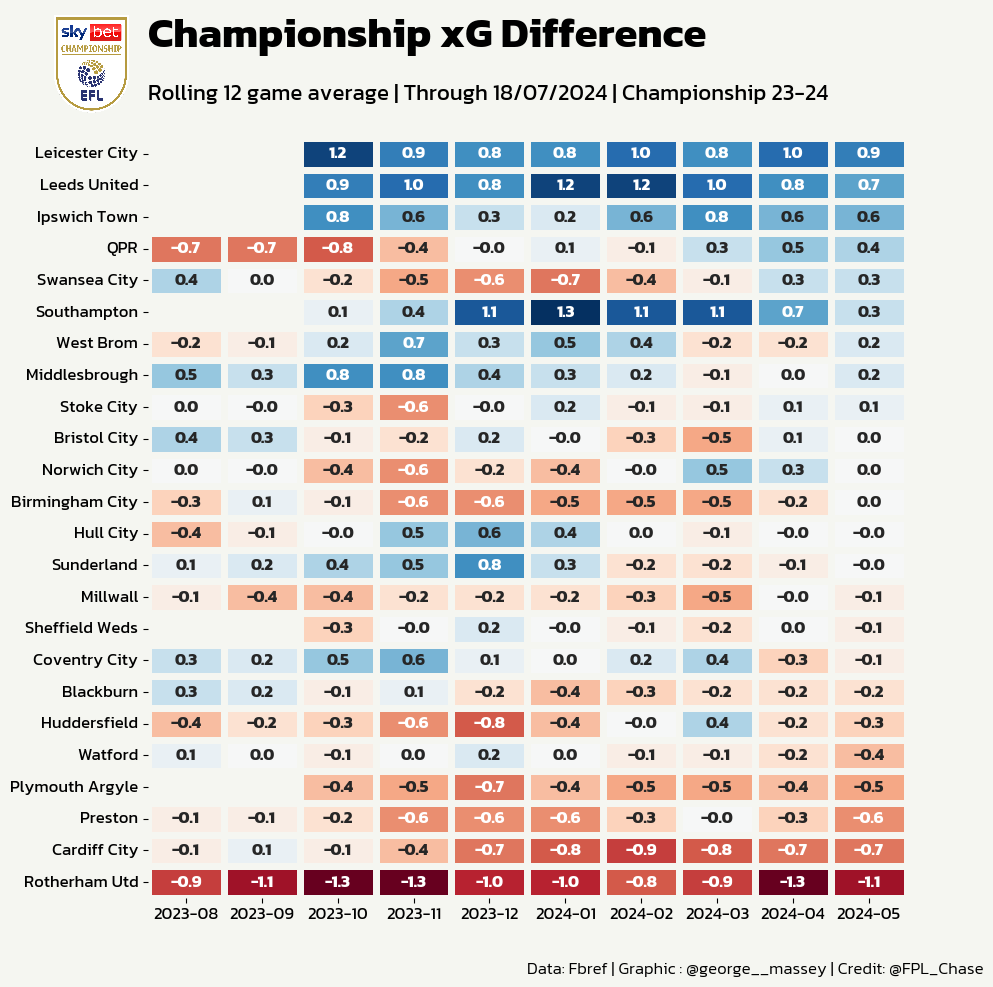

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10), facecolor='#F5F6F1')

nan_mask = pivot_df.isnull()

# Create the heatmap
heatmap = sns.heatmap(pivot_df, 
                      cmap="RdBu",  # Red-Blue diverging colormap
                      center=0,       # Center the colormap at 0
                      annot=True,
                      cbar=False,     # Show values in each cell
                      fmt='.1f',      # Format annotations to 1 decimal place
                      linewidths=5,   # Space between cells
                      linecolor='#F5F6F1',
                      annot_kws={"size": 12, "fontproperties": bold},
                      mask=nan_mask)

ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.

# Set the background color of the heatmap area
ax.set_facecolor('#F5F6F1')

# Customize the plot
plt.xlabel("", fontsize=10)
plt.ylabel("", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(fontproperties=regular, size=12)
plt.yticks(fontproperties=regular, size=12, rotation=0)

plt.text(0,1.12, f"{league} xG Difference", ha = 'left',fontsize=30, transform=plt.gca().transAxes, fontproperties=bold)
plt.text(0,1.05, f"Rolling 12 game average | Through {todays_date} | {league} 23-24", ha = 'left',fontsize=16, transform=plt.gca().transAxes, fontproperties=regular)
plt.text(0.8, -0.1, "Data: Fbref | Graphic : @george__massey | Credit: @FPL_Chase", fontsize=12, ha = 'center',transform=plt.gca().transAxes, fontproperties=light)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
logo_image = plt.imread(f"C:\\Users\\George\\Documents\\Football Analytics\\Images\\{league}_Logo.png")

# Create an OffsetImage instance with the loaded image
logo_offsetimage = OffsetImage(logo_image, zoom=0.045)  # Adjust the zoom value as needed

# Create an AnnotationBbox instance and add it to the plot
logo_box = AnnotationBbox(logo_offsetimage, (-0.025, 1.16), xycoords='axes fraction', box_alignment=(1.0, 1.0), boxcoords="offset pixels")
ax = plt.gca()
ax.add_artist(logo_box)
logo_box.patch.set_alpha(0)
# Adjust layout and display
plt.tight_layout()

plt.savefig(
    f"C:/Users/George/Documents/Football Analytics/Visuals/{league} Rolling xGD.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()